<a href="https://colab.research.google.com/github/mrifkiarya/Group-3---Artifical-Inteligence/blob/main/Group_3_Build_and_evaluate_a_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Find or prepare an Indonesian sentiment dataset (e.g., product reviews, tweets).**

In [29]:
!pip install datasets transformers scikit-learn --quiet

import pandas as pd
from datasets import load_dataset

ds = load_dataset("jakartaresearch/google-play-review")

df = pd.DataFrame({
    'text': ds['train']['text'],
    'label': ds['train']['label']
})

df['label'] = df['label'].map({'pos': 1, 'neg': 0})

pos_df = df[df['label'] == 1].sample(100, random_state=42)
neg_df = df[df['label'] == 0].sample(100, random_state=42)
df = pd.concat([pos_df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

**2. Tokenize using a multilingual or Indonesian-specific BERT model (indobenchmark/indobert-base-p1).**

In [30]:
import torch
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def prepare_data(texts, labels, tokenizer, max_len=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
    return TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels)
    )

train_data = prepare_data(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
test_data = prepare_data(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)

**3. Fine-tune the model, adapting hyperparameters for data size.**

In [31]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader

model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
model.train()
for epoch in range(2):
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} selesai - Loss: {total_loss / len(train_loader):.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 selesai - Loss: 0.4699
Epoch 2 selesai - Loss: 0.2246


**4. Evaluate with accuracy, precision/recall, and confusion matrix.**

=== Evaluasi Model ===
Akurasi : 0.8000
Presisi : 0.7333
Recall  : 1.0000
=== Classification Report ===
              precision    recall  f1-score   support

    Negative       1.00      0.56      0.71        18
    Positive       0.73      1.00      0.85        22

    accuracy                           0.80        40
   macro avg       0.87      0.78      0.78        40
weighted avg       0.85      0.80      0.79        40



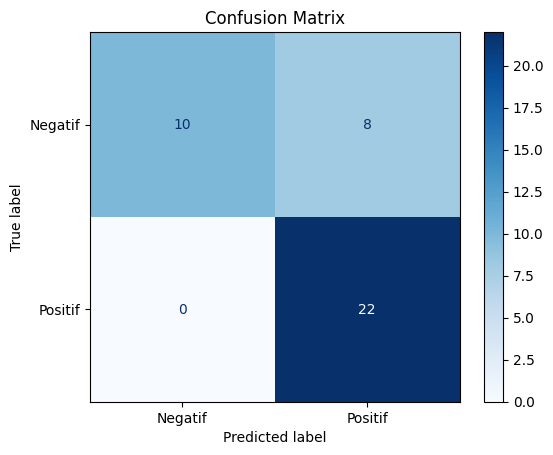

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

model.eval()
predictions = []
true_labels = []

test_loader = DataLoader(test_data, batch_size=8)
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, predictions)
prec = precision_score(true_labels, predictions)
rec = recall_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

print("=== Evaluasi Model ===")
print(f"Akurasi : {acc:.4f}")
print(f"Presisi : {prec:.4f}")
print(f"Recall  : {rec:.4f}")

print("=== Classification Report ===")
print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negatif", "Positif"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

**5. Analyze common error cases and discuss language-specific challenges**

In [35]:
# Error Cases
test_texts = test_df['text'].tolist()
errors = [(text, true, pred) for text, true, pred in zip(test_texts, true_labels, predictions) if true != pred]

print("\nContoh Kasus Salah Prediksi:")
for i, (text, true, pred) in enumerate(errors[:5]):
    print(f"\n{i+1}. Teks: {text}")
    print(f"   Label Asli: {true}, Prediksi: {pred}")

# Language-specific challenges
print("\nTantangan Bahasa Indonesia:")
print("- Banyak kata informal dan tidak baku di review.")
print("- Kata-kata slang/gaul atau singkatan sulit dimengerti model.")
print("- Struktur kalimat yang tidak selalu mengikuti aturan baku.")


Contoh Kasus Salah Prediksi:

1. Teks:  maintenance trus
   Label Asli: 0, Prediksi: 1

2. Teks:  Coba ditingkatka app. ini dgn menambahkan bbrp fitur, spt: chat dengan seller, komplain barang, pembatalan pesanan. Thx.
   Label Asli: 0, Prediksi: 1

3. Teks:  ok
   Label Asli: 0, Prediksi: 1

4. Teks:  Nyoba dulu
   Label Asli: 0, Prediksi: 1

5. Teks:  Please
 add feature to choose delivery courier, it will help the customer to 
choose what courier that more suitable for them, but please keep it 
always free of charge. :)
   Label Asli: 0, Prediksi: 1

Tantangan Bahasa Indonesia:
- Banyak kata informal dan tidak baku di review.
- Kata-kata slang/gaul atau singkatan sulit dimengerti model.
- Struktur kalimat yang tidak selalu mengikuti aturan baku.
